In [40]:
# Install tsflex and seglearn
!pip install tsflex --no-index --find-links=file:///kaggle/input/time-series-tools
!pip install seglearn --no-index --find-links=file:///kaggle/input/time-series-tools

Looking in links: file:///kaggle/input/time-series-tools
Looking in links: file:///kaggle/input/time-series-tools


<p style="font-family: monospace; 
          font-weight: bold; 
          letter-spacing: 2px; 
          color: black; 
          font-size: 200%; 
          text-align: left;
          padding: 0px; 
          border-bottom: 4px solid #78D0AF" >Table of Contents</p>
          
          
* [Data loading and feature extraction](#section-one)
* [EDA on time for targets](#section-two)
* [Build the model and submit](#section-three)


# Data loading and feature extraction 

In [41]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int8','int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [45]:
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
from sklearn import *
import glob

p = '/kaggle/input/tlvmc-parkinsons-freezing-gait-prediction/'

train = glob.glob(p+'train/**/**')
test = glob.glob(p+'test/**/**')
subjects = pd.read_csv(p+'subjects.csv')
tasks = pd.read_csv(p+'tasks.csv')
sub = pd.read_csv(p+'sample_submission.csv')

tdcsfog_metadata=pd.read_csv('/kaggle/input/tlvmc-parkinsons-freezing-gait-prediction/tdcsfog_metadata.csv')
defog_metadata=pd.read_csv('/kaggle/input/tlvmc-parkinsons-freezing-gait-prediction/defog_metadata.csv')
tdcsfog_metadata['Module']='tdcsfog'
defog_metadata['Module']='defog'
# daily_metadata['Module']='daily'
metadata=pd.concat([tdcsfog_metadata,defog_metadata])
# metadata

In [46]:
tasks

,Id,Begin,End,Task
0,02ab235146,10.000,190.480,Rest1
1,02ab235146,211.240,271.560,Rest2
2,02ab235146,505.880,522.400,4MW
3,02ab235146,577.960,594.640,4MW-C
4,02ab235146,701.320,715.280,MB1
...,...,...,...,...
2812,f9fc61ce85,800.586,810.714,TUG-DT
2813,f9fc61ce85,904.416,926.181,Turning-ST
2814,f9fc61ce85,959.211,989.855,Turning-DT
2815,f9fc61ce85,1087.313,1105.086,Hotspot1


In [47]:
# https://www.kaggle.com/code/jazivxt/familiar-solvs
tasks['Duration'] = tasks['End'] - tasks['Begin']
tasks = pd.pivot_table(tasks, values=['Duration'], index=['Id'], columns=['Task'], aggfunc='sum', fill_value=0)
tasks.columns = [c[-1] for c in tasks.columns]
tasks = tasks.reset_index()
tasks['t_kmeans'] = cluster.KMeans(n_clusters=10, random_state=3).fit_predict(tasks[tasks.columns[1:]])

subjects = subjects.fillna(0).groupby('Subject').median()
subjects = subjects.reset_index()
# subjects.rename(columns={'Subject':'Id'}, inplace=True)
subjects['s_kmeans'] = cluster.KMeans(n_clusters=10, random_state=3).fit_predict(subjects[subjects.columns[1:]])
subjects=subjects.rename(columns={'Visit':'s_Visit','Age':'s_Age','YearsSinceDx':'s_YearsSinceDx','UPDRSIII_On':'s_UPDRSIII_On','UPDRSIII_Off':'s_UPDRSIII_Off','NFOGQ':'s_NFOGQ'})

# display(tasks)
# display(subjects)

In [48]:
complex_featlist=['Visit','Test','Medication','s_Visit','s_Age','s_YearsSinceDx','s_UPDRSIII_On','s_UPDRSIII_Off','s_NFOGQ','s_kmeans']
metadata_complex=metadata.merge(subjects,how='left',on='Subject').copy()
metadata_complex['Medication']=metadata_complex['Medication'].factorize()[0]

# display(metadata_complex)

## Create a tsflex feature collection

In [49]:
from seglearn.feature_functions import base_features, emg_features

from tsflex.features import FeatureCollection, MultipleFeatureDescriptors
from tsflex.features.integrations import seglearn_feature_dict_wrapper


basic_feats = MultipleFeatureDescriptors(
    functions=seglearn_feature_dict_wrapper(base_features()),
    series_names=['AccV', 'AccML', 'AccAP'],
    windows=[5_000],
    strides=[5_000],
)

emg_feats = emg_features()
del emg_feats['simple square integral'] # is same as abs_energy (which is in base_features)

emg_feats = MultipleFeatureDescriptors(
    functions=seglearn_feature_dict_wrapper(emg_feats),
    series_names=['AccV', 'AccML', 'AccAP'],
    windows=[5_000],
    strides=[5_000],
)

fc = FeatureCollection([basic_feats, emg_feats])

## Extract the features (with Time_frac feature)

In [50]:

import pathlib
def reader(f):
    try:
        df = pd.read_csv(f, index_col="Time", usecols=['Time', 'AccV', 'AccML', 'AccAP', 'StartHesitation', 'Turn' , 'Walking'])
        
        df['Id'] = f.split('/')[-1].split('.')[0]
        df['Module'] = pathlib.Path(f).parts[-2]
        
        df['Time_frac']=(df.index/df.index.max()).values#currently the index of data is actually "Time"
        
        df = pd.merge(df, tasks[['Id','t_kmeans']], how='left', on='Id').fillna(-1)
#         df = pd.merge(df, subjects[['Id','s_kmeans']], how='left', on='Id').fillna(-1)
        df = pd.merge(df, metadata_complex[['Id','Subject']+['Visit','Test','Medication','s_kmeans']], how='left', on='Id').fillna(-1)
        df_feats = fc.calculate(df, return_df=True, include_final_window=True, approve_sparsity=True, window_idx="begin").astype(np.float32)
        df = df.merge(df_feats, how="left", left_index=True, right_index=True)
        df.fillna(method="ffill", inplace=True)
        return df
    except: pass
train = pd.concat([reader(f) for f in tqdm(train)]).fillna(0); print(train.shape)
cols = [c for c in train.columns if c not in ['Id','Subject','Module', 'Time', 'StartHesitation', 'Turn' , 'Walking', 'Valid', 'Task','Event']]
pcols = ['StartHesitation', 'Turn' , 'Walking']
scols = ['Id', 'StartHesitation', 'Turn' , 'Walking']

  0%|          | 0/970 [00:00<?, ?it/s]

(20588374, 72)


In [52]:
train=train.reset_index(drop=True)

# EDA: Looking at the distribution of Time for different target variable

1. add time feature: `df['Time_frac']=(df.Time/df.Time.max()).values`(finished in reader() function)
2. visualized the distribution of `Time_frac` for different target variable[`StartHesitation,Turn,Walking`]



<AxesSubplot:>

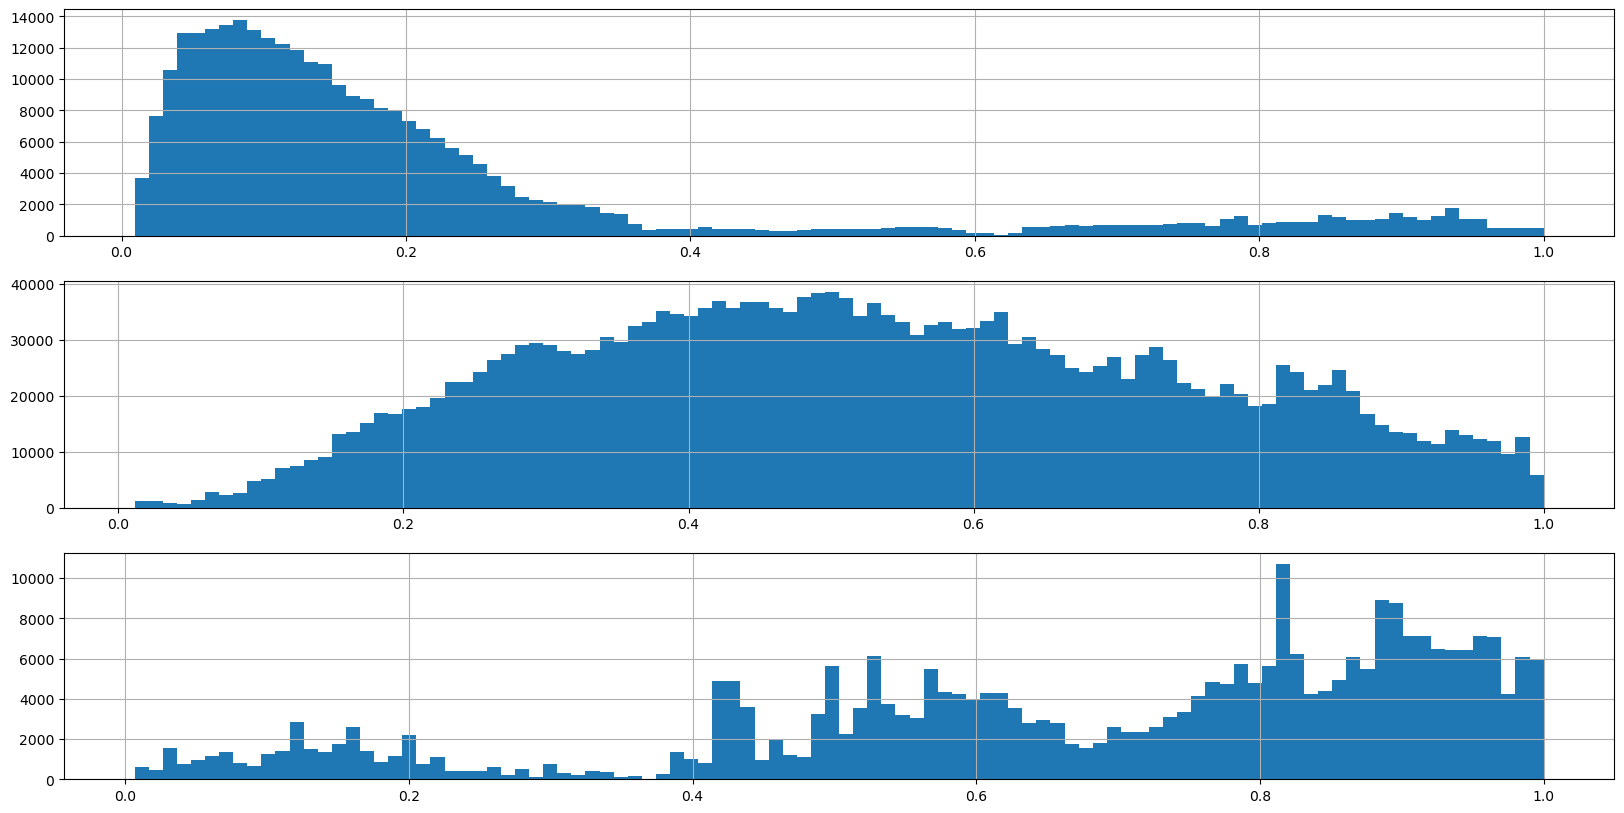

In [53]:
import matplotlib.pyplot as plt
fig,ax=plt.subplots(3,1,figsize=(20,10))
train.loc[train['StartHesitation']==1,'Time_frac'].hist(ax=ax[0],bins=100)
train.loc[train['Turn']==1,'Time_frac'].hist(ax=ax[1],bins=100)
train.loc[train['Walking']==1,'Time_frac'].hist(ax=ax[2],bins=100)

##### The distribution betweeen `the 3 target[StartHesitation,Turn,Walking]` is totally different

##### review the Official definition
> The tDCS FOG (tdcsfog) dataset, comprising data series collected in the lab, as subjects `completed a FOG-provoking protocol`.

> The DeFOG (defog) dataset, comprising data series collected in the subject's home, as subjects `completed a FOG-provoking protocol`

##### EDA Discovery

- StartHesitation frequently occurs in the early stage, and rarely occurs in the late stage
- Turn frequently occurs in the middle stage
- Walking frequently occurs in the late stage

##### Assumption: In a `completed FOG-provoking protocol`, the order in which the event occur tends to follow the order `StartHesitation->Turn->Walking`

##### Application example: Add time fraction feature to model

# Build the model and submit

## Train the model

In [54]:
import lightgbm as lgb
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error, r2_score


In [55]:
import numpy as np
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import uniform, randint
from sklearn.metrics import average_precision_score, make_scorer


#XGBoost hyper-parameter tuning
def hyperParameterTuning(X_train, y_train):
    param_tuning = {
        'learning_rate': [0.01, 0.1],
        'max_depth': [3, 5, 7, 10],
        'min_child_weight': [1, 3, 5],
        'subsample': [0.5, 0.7],
        'colsample_bytree': [0.5, 0.7],
        'n_estimators' : [100, 200, 500],
        'objective': ['reg:squarederror']
    }

    xgb_model = XGBRegressor()

    gsearch = GridSearchCV(estimator = xgb_model,
                           param_grid = param_tuning,                        
                           #scoring = 'neg_mean_absolute_error', #MAE
                           #scoring = 'neg_mean_squared_error',  #MSE
                           cv = 5,
                           n_jobs = -1,
                           verbose = 1)

    gsearch.fit(X_train,y_train)

    return gsearch.best_params_

In [56]:
from sklearn.base import clone

def custom_average_precision(y_true, y_pred):
    score = average_precision_score(y_true, y_pred)
    return 'average_precision', score, True

class LGBMMultiOutputRegressor(MultiOutputRegressor):
    def fit(self, X, y, eval_set=None, **fit_params):
        self.estimators_ = [clone(self.estimator) for _ in range(y.shape[1])]
        
        for i, estimator in enumerate(self.estimators_):
            if eval_set:
                fit_params['eval_set'] = [(eval_set[0], eval_set[1][:, i])]
            estimator.fit(X, y[:, i], **fit_params)
        
        return self

In [ ]:
from sklearn.model_selection import GroupKFold

N_FOLDS=5
kfold = GroupKFold(N_FOLDS)
group_var = train.Subject
groups=kfold.split(train, groups=group_var)
print(len(group_var))
x_tr, x_te, y_tr,y_te = train_test_split(train.loc[tr_idx,cols].to_numpy(),train.loc[tr_idx,pcols].to_numpy(), test_size=0.8)
x_te, y_te = train.loc[te_idx,cols].to_numpy(),train.loc[te_idx,pcols].to_numpy()

20588374


In [ ]:
x_tr.shape

In [ ]:
y_tr.shape

In [ ]:
x_te.shape

In [77]:
best_params_ = {'estimator__colsample_bytree': 0.5282057895135501, 
 'estimator__learning_rate': 0.22659963168004743, 
 'estimator__max_depth': 8, 
 'estimator__min_child_weight': 3.1233911067827616, 
 'estimator__n_estimators': 291, 
 'estimator__subsample': 0.9961057796456088}

In [78]:
best_params_ = {kk: v for k, v in best_params_.items() for kk in k.split('__')}; del best_params_['estimator']

In [79]:
# Create a base XGBoost regressor with the common parameters
base_regressor = lgb.LGBMRegressor(**best_params_)

# Wrap the base regressor with the MultiOutputRegressor
multioutput_regressor = LGBMMultiOutputRegressor(base_regressor)
multioutput_regressor.fit(
    x_tr,y_tr,
    eval_set=(x_te,y_te),
    eval_metric=custom_average_precision,
    early_stopping_rounds=30
    )

/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's l2: 0.00307782	valid_0's average_precision: 0.635527
[2]	valid_0's l2: 0.00251995	valid_0's average_precision: 0.703871
[3]	valid_0's l2: 0.00224464	valid_0's average_precision: 0.716525
[4]	valid_0's l2: 0.00208332	valid_0's average_precision: 0.728494
[5]	valid_0's l2: 0.00187426	valid_0's average_precision: 0.752078
[6]	valid_0's l2: 0.00171998	valid_0's average_precision: 0.773223
[7]	valid_0's l2: 0.00161917	valid_0's average_precision: 0.789958
[8]	valid_0's l2: 0.00154756	valid_0's average_precision: 0.803553
[9]	valid_0's l2: 0.00151469	valid_0's average_precision: 0.808735
[10]	valid_0's l2: 0.00149135	valid_0's average_precision: 0.813039
[11]	valid_0's l2: 0.00147746	valid_0's average_precision: 0.813529
[12]	valid_0's l2: 0.00145306	valid_0's average_precision: 0.818311
[13]	valid_0's l2: 0.00143493	valid_0's average_precision: 0.824871
[14]	valid_0's l2: 0.00142273	valid_0's average_precision: 0.826817
[15]	valid_0's l2: 0.00135505	valid_0's average_precision

/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's l2: 0.0632449	valid_0's average_precision: 0.559507
[2]	valid_0's l2: 0.0558484	valid_0's average_precision: 0.628703
[3]	valid_0's l2: 0.0511847	valid_0's average_precision: 0.658388
[4]	valid_0's l2: 0.0481068	valid_0's average_precision: 0.673346
[5]	valid_0's l2: 0.0450336	valid_0's average_precision: 0.700062
[6]	valid_0's l2: 0.0429465	valid_0's average_precision: 0.71513
[7]	valid_0's l2: 0.0413099	valid_0's average_precision: 0.724059
[8]	valid_0's l2: 0.0400427	valid_0's average_precision: 0.73326
[9]	valid_0's l2: 0.0392064	valid_0's average_precision: 0.738832
[10]	valid_0's l2: 0.0384539	valid_0's average_precision: 0.744336
[11]	valid_0's l2: 0.0378781	valid_0's average_precision: 0.748932
[12]	valid_0's l2: 0.0370429	valid_0's average_precision: 0.758639
[13]	valid_0's l2: 0.0363153	valid_0's average_precision: 0.765233
[14]	valid_0's l2: 0.0357525	valid_0's average_precision: 0.769348
[15]	valid_0's l2: 0.0351798	valid_0's average_precision: 0.775994
[16]	v

KeyboardInterrupt: 

In [13]:
best_params_

{'colsample_bytree': 0.5282057895135501,
 'learning_rate': 0.22659963168004743,
 'max_depth': 8,
 'min_child_weight': 3.1233911067827616,
 'n_estimators': 291,
 'subsample': 0.9961057796456088}

In [14]:

regs=[]
cvs=[]
for fold, (tr_idx,te_idx ) in enumerate(tqdm(groups, total=N_FOLDS, desc="Folds")):
    tr_idx=pd.Series(tr_idx).sample(n=2000000,random_state=564).values #2000000
    
    # Create a base XGBoost regressor with the common parameters
    base_regressor = lgb.LGBMRegressor(**best_params_)

    # Wrap the base regressor with the MultiOutputRegressor
    multioutput_regressor = LGBMMultiOutputRegressor(base_regressor)

    x_tr,y_tr=train.loc[tr_idx,cols].to_numpy(),train.loc[tr_idx,pcols].to_numpy()
    x_te,y_te=train.loc[te_idx,cols].to_numpy(),train.loc[te_idx,pcols].to_numpy()

    multioutput_regressor.fit(
    x_tr,y_tr,
    eval_set=(x_te,y_te),
    eval_metric=custom_average_precision,
    early_stopping_rounds=30
    )
    regs.append(multioutput_regressor)
    cv=metrics.average_precision_score(y_te, multioutput_regressor.predict(x_te).clip(0.0,1.0))
    cvs.append(cv)
print(cvs)

Folds:   0%|          | 0/5 [00:00<?, ?it/s]

NameError: name 'LGBMMultiOutputRegressor' is not defined

## Predict for test

In [ ]:
sub['t'] = 0
submission = []
for f in test:
    df = pd.read_csv(f)
    df.set_index('Time', drop=True, inplace=True)

    df['Id'] = f.split('/')[-1].split('.')[0]
    df['Time_frac']=(df.index/df.index.max()).values#currently the index of data is actually "Time"
    df = pd.merge(df, tasks[['Id','t_kmeans']], how='left', on='Id').fillna(-1)
    df = pd.merge(df, metadata_complex[['Id','Subject']+['Visit','Test','Medication','s_kmeans']], how='left', on='Id').fillna(-1)
    df_feats = fc.calculate(df, return_df=True, include_final_window=True, approve_sparsity=True, window_idx="begin")
    df = df.merge(df_feats, how="left", left_index=True, right_index=True)
    df.fillna(method="ffill", inplace=True)
    
    res_vals=[]
    for i_fold in range(N_FOLDS):
        res_val=np.round(regs[i_fold].predict(df[cols]).clip(0.0,1.0),3)
        res_vals.append(np.expand_dims(res_val,axis=2))
    res_vals=np.mean(np.concatenate(res_vals,axis=2),axis=2)
    res = pd.DataFrame(res_vals, columns=pcols)
    
    df = pd.concat([df,res], axis=1)
    df['Id'] = df['Id'].astype(str) + '_' + df.index.astype(str)
    submission.append(df[scols])
submission = pd.concat(submission)
submission = pd.merge(sub[['Id']], submission, how='left', on='Id').fillna(0.0)
submission[scols].to_csv('submission.csv', index=False)